- **In this notebook, we compute popular risk measures** such as **Value at Risk (VaR)** and **Conditional VaR (CVaR)** using historical stock data, parametric fitting, and Monte Carlo simulations. Stock data is extracted using the `yfinance` package.
- **Workflow Overview:**
    - **Part 1:** Ignore asset correlations and fit a univariate distribution to aggregated portfolio returns.
    - **Part 2:** Use multivariate distributions to account for correlations between assets.
- **Goals:**
    - Fit historical data to **normal** and **t-distributions**, and compare their risk metric predictions.
    - Analyze the effect of asset correlations by fitting the data to a **multivariate distribution**.
    - Analyze how the model would perform during the **2008 Financial Crisis** and the **COVID Crisis**
        

In [90]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [91]:
import pandas as pd
import yfinance as yf
import time

tickers = ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AMZN']
start_date = '2010-01-01'
end_date = '2019-12-01'

adj_close_data = {}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    t = yf.Ticker(ticker)
    df = t.history(start=start_date, end=end_date)
    adj_close_data[ticker] = df['Close']  # or 'Adj Close' if available
    time.sleep(0.5)  # optional delay

# Combine into dataframe
data = pd.DataFrame(adj_close_data)
print(data.head())


                               AAPL       MSFT       GOOG      NVDA    AMZN
Date                                                                       
2010-01-04 00:00:00-05:00  6.431897  23.211441  15.517998  0.423854  6.6950
2010-01-05 00:00:00-05:00  6.443017  23.218937  15.449661  0.430044  6.7345
2010-01-06 00:00:00-05:00  6.340532  23.076439  15.060196  0.432794  6.6125
2010-01-07 00:00:00-05:00  6.328810  22.836460  14.709599  0.424313  6.5000
2010-01-08 00:00:00-05:00  6.370887  22.993944  14.905696  0.425230  6.6760


In [92]:
data.tail()

,AAPL,MSFT,GOOG,NVDA,AMZN
Date,,,,,
2019-11-22 00:00:00-05:00,63.295090,142.532684,64.384293,5.245522,87.286003
2019-11-25 00:00:00-05:00,64.404907,144.095322,64.948441,5.502213,88.692001
2019-11-26 00:00:00-05:00,63.901974,144.857529,65.289413,5.397498,89.847000
2019-11-27 00:00:00-05:00,64.760323,145.133896,65.261574,5.432345,90.925499
2019-11-29 00:00:00-05:00,64.617683,144.238251,64.862450,5.395009,90.040001


In [93]:
data.shape

(2495, 5)

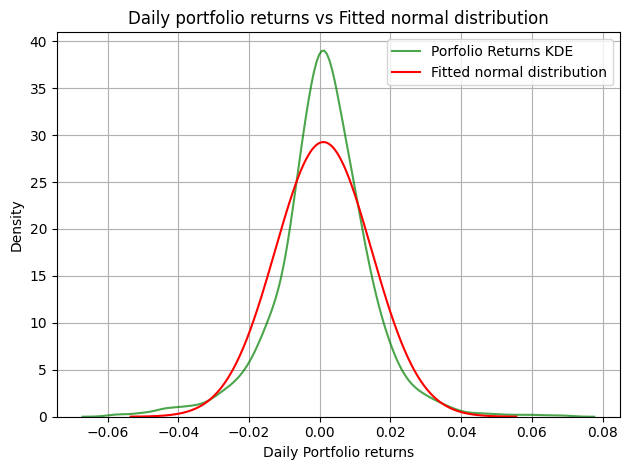

In [94]:
# returns = data.pct_change().dropna()
returns = data.pct_change().dropna()

# Portfolio weights (equal weights as example)
weights = np.array([1/len(tickers)] * len(tickers))

# Portfolio daily returns -
portfolio_returns = returns.dot(weights)
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()
import seaborn as sns
sns.kdeplot(portfolio_returns, color='green', fill=False, alpha=0.7, label='Porfolio Returns KDE')
from scipy.stats import norm
x=np.linspace(mean-4*std_dev,mean+4*std_dev,1000)
plt.plot(x,norm.pdf(x, mean, std_dev),'r-', label='Fitted normal distribution')
plt.title('Daily portfolio returns vs Fitted normal distribution')
plt.xlabel('Daily Portfolio returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
from scipy.stats import shapiro
stat, p_value = shapiro(portfolio_returns)
print(f"Shapiro-Wilk p-value: {p_value:.4f}")


Shapiro-Wilk p-value: 0.0000


In [96]:
returns.shape

(2494, 5)

## It looks like a bad fit, the p value is 0. Thus we can reject the null hypothesis(that the data is drawn from a normal)

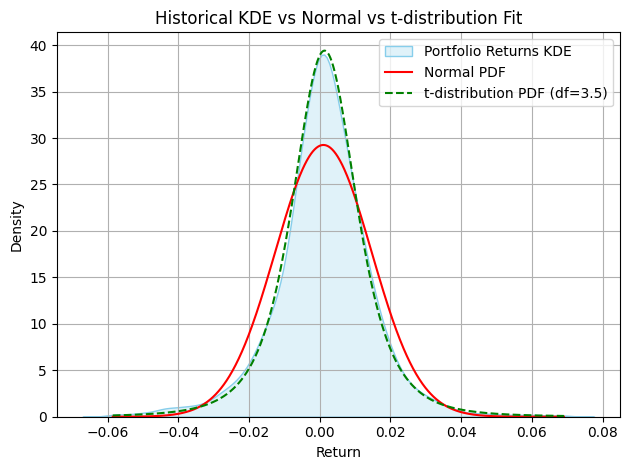

In [97]:
from scipy.stats import t

# Fit a t-distribution to portfolio returns
df, loc, scale = t.fit(portfolio_returns)

# Compare fit with KDE and normal
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)

sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio Returns KDE')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'r-', label='Normal PDF')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')


plt.title("Historical KDE vs Normal vs t-distribution Fit")
plt.xlabel("Return")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [98]:


# Fit both
df_t, loc_t, scale_t = t.fit(portfolio_returns)
loc_n, scale_n = norm.fit(portfolio_returns)

# Compute log-likelihoods
loglik_t = np.sum(t.logpdf(portfolio_returns, df_t, loc_t, scale_t))
loglik_n = np.sum(norm.logpdf(portfolio_returns, loc_n, scale_n))

# AIC = 2k - 2logL  (k = number of parameters)
AIC_t = 2*3 - 2*loglik_t  # t has 3 parameters
AIC_n = 2*2 - 2*loglik_n  # normal has 2 parameters

print(f"AIC (t): {AIC_t:.2f}")
print(f"AIC (normal): {AIC_n:.2f}")


AIC (t): -14658.10
AIC (normal): -14342.64


In [99]:
from scipy.stats import kstest, t

# Perform K-S test for normal distribution
ks_stat_n, ks_p_n = kstest(portfolio_returns, 'norm', args=(mean, std_dev))
print(f"KS statistic (normal): {ks_stat_n:.4f}, p-value: {ks_p_n:.4f}")

# Perform K-S test
ks_stat, ks_p = kstest(portfolio_returns, 't', args=(df, loc, scale))
print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")


KS statistic (normal): 0.0690, p-value: 0.0000
KS statistic: 0.0148, p-value: 0.6400


## The KS Statistic is lower and the p-value is higher for the t-distribution, indicating a better fit than the normal distribution.

In [100]:
#  Parametric VaR (Variance-Covariance, assuming t) 
confidence_level = 0.95
param_VaR_t = stats.t.ppf(1 - confidence_level, df, loc, scale)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = loc + scale * np.random.standard_t(df, size=n_simulations)
mc_VaR_t = np.percentile(simulated_returns, (1-confidence_level)*100)

t_CVaR = simulated_returns[simulated_returns <= mc_VaR_t].mean()

# Print results
print(f"=== Portfolio Risk Metrics with t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"Parametric VaR_t: {param_VaR_t:.4f}")
print(f"Monte Carlo VaR_t: {mc_VaR_t:.4f}")
print(f"Monte Carlo CVaR (95%): {t_CVaR:.4f}")



=== Portfolio Risk Metrics with t-distribution (95% confidence) ===
Parametric VaR_t: -0.0197
Monte Carlo VaR_t: -0.0190
Monte Carlo CVaR (95%): -0.0305


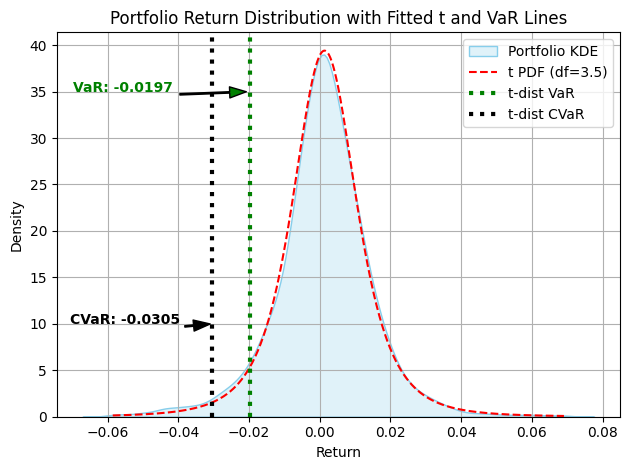

In [101]:
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio KDE')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'r--', label=f't PDF (df={df:.1f})')

# VaR lines
plt.axvline(param_VaR_t, color='green', linestyle=':', linewidth = 3, label='t-dist VaR')
plt.axvline(t_CVaR,color='black', linestyle=':', linewidth = 3, label = 't-dist CVaR')
plt.annotate(
    f'VaR: {param_VaR_t:.4f}',
    xy=(param_VaR_t, 35),
    xytext=(param_VaR_t-0.05, 35),
    arrowprops=dict(facecolor='green', shrink=0.05, width=1, headwidth=8),
    color='green',
    fontsize=10,
    fontweight='bold'
)
plt.annotate(
    f'CVaR: {t_CVaR:.4f}',
    xy=(t_CVaR, 10),
    xytext=(t_CVaR-0.04, 10),
    arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
    color='black',
    fontsize=10,
    fontweight='bold'
)
plt.title('Portfolio Return Distribution with Fitted t and VaR Lines')
plt.xlabel('Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Now lets study the stock prices individually, and see if their correlations have an impact on the final predictions

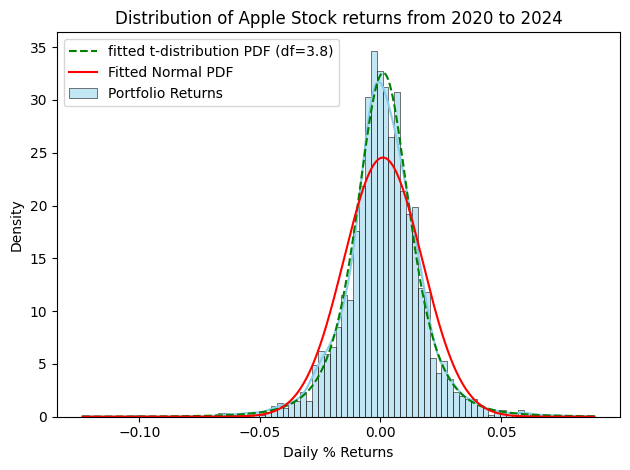

In [102]:
df,loc,scale = t.fit(returns['AAPL'])
fitted_norm=norm.fit(returns['AAPL'])
x= np.linspace(returns['AAPL'].min(), returns['AAPL'].max(), 1000)
sns.histplot(returns['AAPL'], kde=True, stat='density', color='skyblue', label='Portfolio Returns')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g--', label=f'fitted t-distribution PDF (df={df:.1f})')
plt.plot(x, norm.pdf(x, loc=fitted_norm[0], scale=fitted_norm[1]), 'r-', label='Fitted Normal PDF')
plt.legend()
plt.title('Distribution of Apple Stock returns from 2020 to 2024')
plt.xlabel('Daily % Returns')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [103]:
returns_AAPL = returns['AAPL']
df_t, loc_t, scale_t = t.fit(returns_AAPL)
loc_n, scale_n = norm.fit(returns_AAPL)

# Compute log-likelihoods
loglik_t = np.sum(t.logpdf(returns_AAPL, df_t, loc_t, scale_t))
loglik_n = np.sum(norm.logpdf(returns_AAPL, loc_n, scale_n))

# AIC = 2k - 2logL  (k = number of parameters)
AIC_t = 2*3 - 2*loglik_t  # t has 3 parameters
AIC_n = 2*2 - 2*loglik_n  # normal has 2 parameters

print(f"AIC (t): {AIC_t:.2f}")
print(f"AIC (normal): {AIC_n:.2f}")

AIC (t): -13807.79
AIC (normal): -13465.93


In [104]:
ks_stat_n, ks_p_n = kstest(returns_AAPL, 'norm', args=(loc_n, scale_n))
print(f"KS statistic (normal): {ks_stat_n:.4f}, p-value: {ks_p_n:.4f}")

# Perform K-S test
ks_stat, ks_p = kstest(returns_AAPL, 't', args=(df_t, loc_t, scale_t))
print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")


KS statistic (normal): 0.0658, p-value: 0.0000
KS statistic: 0.0149, p-value: 0.6323


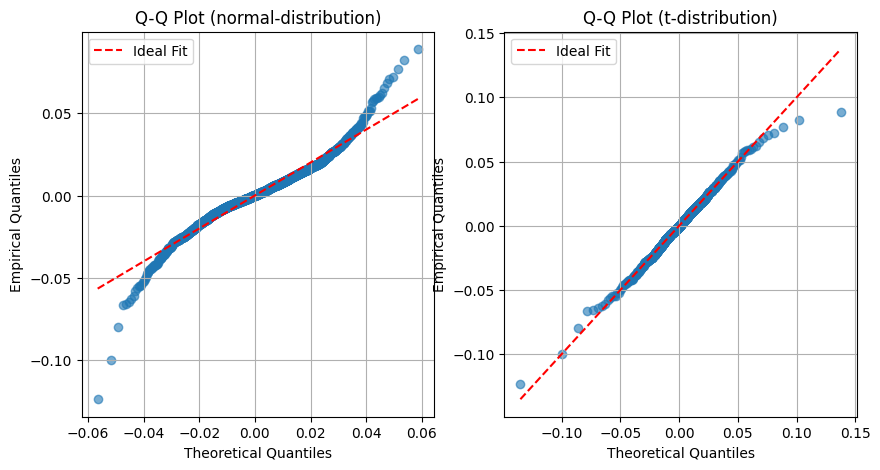

In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, t

def qq_plot(data, ax, dist='normal', df=None, loc=None, scale=None):
    """
    Generate a Q-Q plot comparing data to a theoretical distribution.
    
    Parameters:
        data: array-like
        dist: 'normal' or 't'
        df, loc, scale: parameters for t-distribution if applicable
    """
    data_sorted = np.sort(data)
    n = len(data)
    probs = (np.arange(1, n+1) - 0.5) / n  # plotting positions
    
    if dist == 'normal':
        theoretical_quantiles = norm.ppf(probs, loc=np.mean(data), scale=np.std(data))
    elif dist == 't':
        if df is None or loc is None or scale is None:
            df, loc, scale = t.fit(data)
        theoretical_quantiles = t.ppf(probs, df, loc=loc, scale=scale)
    else:
        raise ValueError("dist must be 'normal' or 't'")
    
    #plt.figure(figsize=(5,5))
    ax.scatter(theoretical_quantiles, data_sorted, alpha=0.6)
    ax.plot(theoretical_quantiles, theoretical_quantiles, 'r--', label='Ideal Fit')
    ax.set_title(f"Q-Q Plot ({dist}-distribution)")
    ax.set_xlabel("Theoretical Quantiles")
    ax.set_ylabel("Empirical Quantiles")
    ax.legend()
    ax.grid(True)
   

# Example usage:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
qq_plot(returns_AAPL, ax[0], dist='normal')
qq_plot(returns_AAPL, ax[1], dist='t')


## The t approximates the tails better

Text(0.5, 1.02, 'Pairplot of Stock Returns')

<Figure size 300x300 with 0 Axes>

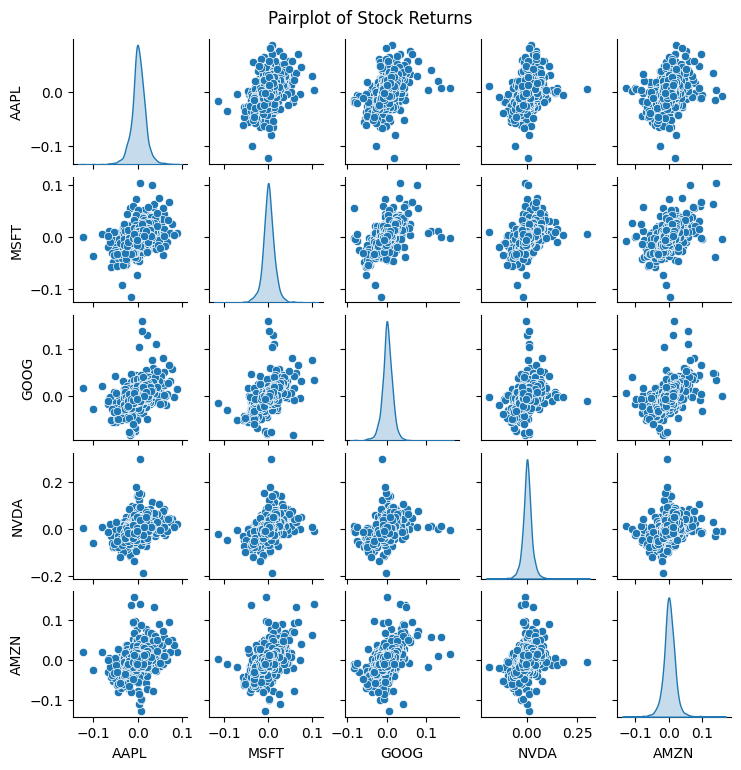

In [117]:
sns.pairplot(returns, diag_kind='kde', markers='o', height=1.5)
plt.suptitle('Pairplot of Stock Returns', y=1.02)

## As we can see, all the stocks are strongly correlated with one another

Text(0.5, 1.0, 'Correlation Matrix of Stock Returns')

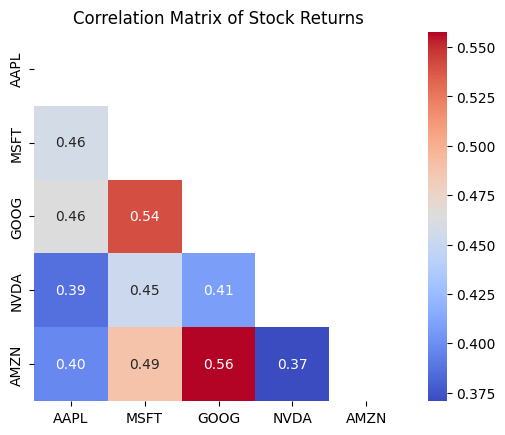

In [108]:

mask= np.triu(np.ones_like(returns.corr(), dtype=bool))
mask2 = returns.corr().abs() <= 1
sns.heatmap(returns.corr(), mask=mask & mask2,annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Stock Returns')

In [109]:
import numpy as np

n_samples = 10000
df = 3.7  # degrees of freedom (low df = fat tails)

# mean vector and covariance matrix from your return data
mean_vec = returns.mean().values           # shape: (n_assets,)
cov_matrix = returns.cov().values          # shape: (n_assets, n_assets)
n_assets = len(mean_vec)

# === Step 2: Simulate from multivariate normal ===
z = np.random.multivariate_normal(mean=mean_vec, cov=cov_matrix, size=n_samples)  # shape: (n_samples, n_assets)

#=== Step 3: Scale by sqrt of Gamma to get t-distribution ===
g = np.random.gamma(df / 2., 2. / df, size=n_samples)  # shape: (n_samples,)
scaling = np.sqrt(g)[:, None]  # reshape for broadcasting

# Simulate multivariate t
mvt_samples = mean_vec + (z - mean_vec) / scaling  # shape: (n_samples, n_assets)



=== Portfolio Risk Metrics with Multivariate t-distribution (95% confidence) ===
VaR_mvt: -0.0287
CVaR_mvt: -0.0425


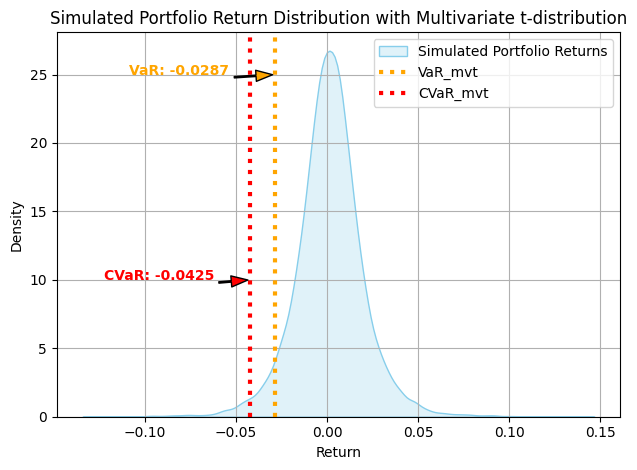

In [127]:
VaR_mvt = np.percentile(portfolio_returns_mvt, (1-confidence_level)*100)
CVaR_mvt = portfolio_returns_mvt[portfolio_returns_mvt <= VaR_mvt].mean()
print(f"=== Portfolio Risk Metrics with Multivariate t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"VaR_mvt: {VaR_mvt:.4f}")            
print(f"CVaR_mvt: {CVaR_mvt:.4f}")
# Dashboard plot        
x = np.linspace(-0.1, 0.1, 1000)
sns.kdeplot(portfolio_returns_mvt, fill=True, color='skyblue', label='Simulated Portfolio Returns')
#plt.plot(x, no.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')
plt.axvline(VaR_mvt, color='orange', linestyle=':', linewidth = 3, label='VaR_mvt')
plt.axvline(CVaR_mvt, color='red', linestyle=':', linewidth = 3, label='CVaR_mvt')
plt.annotate(
    f'VaR: {VaR_mvt:.4f}',
    xy=(VaR_mvt, 25),
    xytext=(VaR_mvt-0.08, 25),
    arrowprops=dict(facecolor='orange', shrink=0.05, width=1, headwidth=8),
    color='orange',
    fontsize=10,
    fontweight='bold'
)
plt.annotate(
    f'CVaR: {CVaR_mvt:.4f}',
    xy=(CVaR_mvt, 10),
    xytext=(CVaR_mvt-0.08, 10),
    arrowprops=dict(facecolor='red', shrink=0.05, width=1, headwidth=8),
    color='red',
    fontsize=10,
    fontweight='bold'
)
plt.title('Simulated Portfolio Return Distribution with Multivariate t-distribution')
plt.legend()
#plt.xlim(-1,1)
plt.xlabel('Return')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()

## Both the VaR and CVaR are much higher when considering multivariate distributions - this is because correlations between these stocks are now considered

[*********************100%***********************]  5 of 5 completed



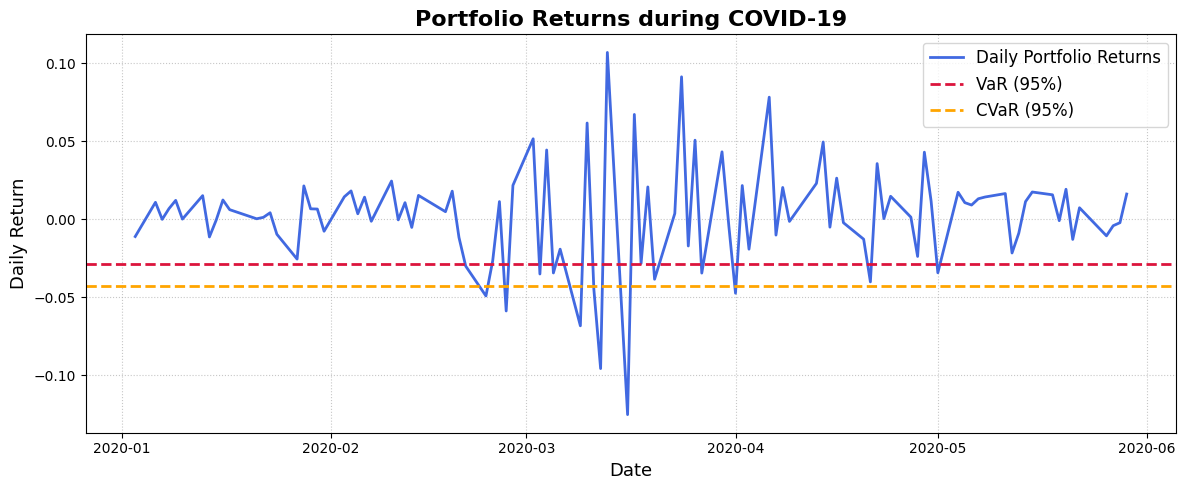

In [128]:
covid_data = yf.download(tickers, start="2020-01-01", end="2020-06-01")['Close']
covid_returns = covid_data.pct_change().dropna().dot(weights)

plt.figure(figsize=(12, 5))
plt.plot(covid_returns.index, covid_returns, label='Daily Portfolio Returns', color='royalblue', linewidth=2)
plt.axhline(y=VaR_mvt, color='crimson', linestyle='--', linewidth=2, label=f'VaR ({confidence_level*100:.0f}%)')
plt.axhline(y=CVaR_mvt, color='orange', linestyle='--', linewidth=2, label=f'CVaR ({confidence_level*100:.0f}%)')
plt.title('Portfolio Returns during COVID-19', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Daily Return', fontsize=13)
plt.legend(fontsize=12, frameon=True)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

[*********************100%***********************]  5 of 5 completed



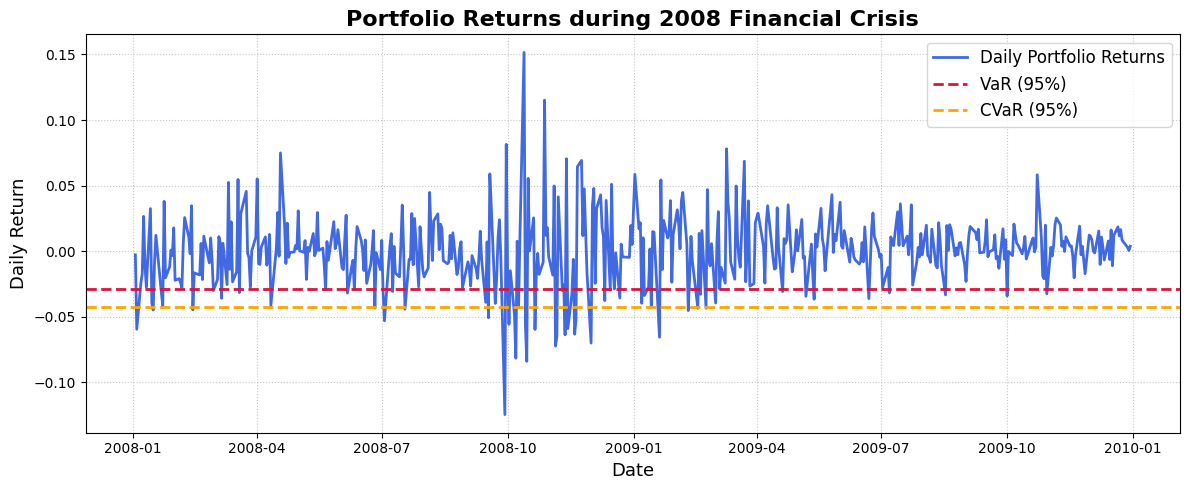

In [133]:
crisis_data = yf.download(tickers, start="2008-01-01", end="2009-12-31")['Close']
crisis_returns = crisis_data.pct_change().dropna().dot(weights)

plt.figure(figsize=(12, 5))
plt.plot(covid_returns.index, covid_returns, label='Daily Portfolio Returns', color='royalblue', linewidth=2)
plt.axhline(y=VaR_mvt, color='crimson', linestyle='--', linewidth=2, label=f'VaR ({confidence_level*100:.0f}%)')
plt.axhline(y=CVaR_mvt, color='orange', linestyle='--', linewidth=2, label=f'CVaR ({confidence_level*100:.0f}%)')
plt.title('Portfolio Returns during 2008 Financial Crisis', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Daily Return', fontsize=13)
plt.legend(fontsize=12, frameon=True)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

In [132]:
# Create a summary DataFrame for final reporting
summary_df = pd.DataFrame({
    "Method": [
        "Univariate t (no correlation)",
        "Multivariate t (with correlation)"
    ],
    "VaR (95%)": [
        param_VaR_t,
        VaR_mvt
    ],
    "CVaR (95%)": [
        t_CVaR,
        CVaR_mvt
    ]
})

# Format for better readability
summary_df["VaR (95%)"] = summary_df["VaR (95%)"].map("{:.4f}".format)
summary_df["CVaR (95%)"] = summary_df["CVaR (95%)"].map("{:.4f}".format)

display(summary_df)

,Method,VaR (95%),CVaR (95%)
0,Univariate t (no correlation),-0.0197,-0.0305
1,Multivariate t (with correlation),-0.0287,-0.0425


- **Downloaded historical price data** for a portfolio of large-cap tech stocks: **AAPL, MSFT, GOOG, NVDA, AMZN** using `yfinance`.
- **Computed daily returns** and constructed an **equally weighted portfolio**.
- **Visualized the empirical distribution** of portfolio returns and compared it to fitted **normal** and **Student's t-distributions**.
- **Calculated Value at Risk (VaR)** and **Conditional VaR (CVaR)** using:
    - Historical method
    - Parametric methods (normal and t-distribution)
    - Monte Carlo simulation
- **Found that the t-distribution provides a better fit** to the empirical return distribution, especially in the tails.
- **Analyzed individual stock return distributions** and visualized **pairwise correlations** using pairplots and heatmaps.
- **Simulated portfolio returns** using both **multivariate normal** and **multivariate t-distributions** to account for asset correlations.
- **Observed that incorporating asset correlations and fat tails** (via the multivariate t) **significantly increases estimated risk metrics** (VaR, CVaR).
- **Compared risk metrics** across all methods, highlighting the importance of modeling both **tail risk** and **correlations** in risk estimation.
- **Applied the methodology to COVID-19 and 2008 crisis periods** to observe risk under extreme market conditions.